## **Imports**

In [7]:
import time
import os
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.io import loadmat

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.image import resize


## **Dataset**

In [10]:
joints = loadmat('../lsp/joints.mat')['joints'].transpose()

original_images = []
resized_images = []
resized_joints = []
original_scale = []

for i in range(2000):
  img = image.load_img(f'../lsp/images/im{i + 1:04d}.jpg')
  img = image.img_to_array(img)
  h, w = img.shape[0], img.shape[1]

  original_scale.append([1 / w, 1 / h])
  original_images.append(img)
  
  resized_joints.append(np.matmul(joints[i, :, 0:2], np.array([[1 / w, 0], [0, 1 / h]])) - np.full((14, 2), 0.5))
  resized_images.append(resize(img, (220, 220)))

original_scale = np.array(original_scale)
resized_joints = np.array(resized_joints)
resized_images = np.array(resized_images)

x_train = resized_images[:1400] / 255.0 - 0.5
y_train = resized_joints[:1400].reshape((-1, 28))

x_valid = resized_images[1400:1700] / 255.0 - 0.5
y_valid = resized_joints[1400:1700].reshape((-1, 28))

x_test = resized_images[1700:] / 255.0 - 0.5
y_test = resized_joints[1700:].reshape((-1, 28))


## **Basic Functions**

In [11]:
class EpochDots(tf.keras.callbacks.Callback):

  def __init__(self, report_every=100, dot_every=1):
    self.report_every = report_every
    self.dot_every = dot_every
    self.start_time = None
    self.current_time = None

  def on_epoch_begin(self, epoch, logs):
    if epoch == 0:
      self.start_time = time.time()
      self.elapsed_time = 0.0

  def on_epoch_end(self, epoch, logs):
    self.elapsed_time = time.time() - self.start_time

    if epoch % self.report_every == 0:
      print()
      print(f'Epoch: {epoch}', end='')
      print(f' - Time: {self.elapsed_time:.1f}s')
      
      loss = logs['loss']
      val_loss = logs['val_loss']
      print(f' - loss: {loss:0.4f} - val_loss: {val_loss:0.4f}')

    if epoch % self.dot_every == 0:
      print('.', end='', flush=True)

  def get_elapsed_time(self):
    return self.elapsed_time


def get_limbs(joints):

  limbs = np.zeros((joints.shape[0], 20, 2))
  limbs[:, 0:2 ,:] = joints[:, 0:2, :]
  limbs[:, 2:4 ,:] = joints[:, 1:3, :]
  limbs[:, 4:6 ,:] = joints[:, 3:5, :]
  limbs[:, 6:8 ,:] = joints[:, 4:6, :]
  limbs[:, 8:10 ,:] = joints[:, 6:8, :]
  limbs[:, 10:12 ,:] = joints[:, 7:9, :]
  limbs[:, 12:14 ,:] = joints[:, 9:11, :]
  limbs[:, 14:16 ,:] = joints[:, 10:12, :]
  limbs[:, 16:18 ,:] = joints[:, 12:14, :]
  limbs[:, 18 ,:] = np.mean(joints[:, 2:4, :], axis=1)
  limbs[:, 19 ,:] = np.mean(joints[:, 8:10, :], axis=1)

  return limbs


def PCP(y_true, y_pred, m ,n):
  joints_true = tf.reshape(y_true, (-1, 14, 2))
  joints_pred = tf.reshape(y_pred, (-1, 14, 2))
  limb_len = tf.norm(joints_true[:, m, :] - joints_true[:, n, :], axis=1)
  j1_err = tf.norm(joints_pred[:, m, :] - joints_true[:, m, :], axis=1)
  j2_err = tf.norm(joints_pred[:, n, :] - joints_true[:, n, :], axis=1)
  pcp = tf.math.logical_and(tf.math.less(j1_err, 0.5 * limb_len), tf.math.less(j2_err, 0.5 * limb_len))
  return tf.reduce_mean(tf.cast(pcp, tf.float32))

def PCP0(y_true, y_pred):
  return PCP(y_true, y_pred, 0 ,1)

def PCP1(y_true, y_pred):
  return PCP(y_true, y_pred, 1 ,2)

def PCP2(y_true, y_pred):
  return PCP(y_true, y_pred, 3 ,4)

def PCP3(y_true, y_pred):
  return PCP(y_true, y_pred, 4 ,5)

def PCP4(y_true, y_pred):
  return PCP(y_true, y_pred, 6 ,7)

def PCP5(y_true, y_pred):
  return PCP(y_true, y_pred, 7 ,8)

def PCP6(y_true, y_pred):
  return PCP(y_true, y_pred, 9 ,10)

def PCP7(y_true, y_pred):
  return PCP(y_true, y_pred, 10 ,11)

def PCP8(y_true, y_pred):
  return PCP(y_true, y_pred, 12 ,13)

def PCP9(y_true, y_pred):
  joints_true = tf.reshape(y_true, (-1, 14, 2))
  joints_pred = tf.reshape(y_pred, (-1, 14, 2))
  limb_len = tf.norm(joints_true[:, 2, :] + joints_true[:, 3, :] - joints_true[:, 8, :] - joints_true[:, 9, :], axis=1) / 2
  j1_err = tf.norm(joints_pred[:, 2, :] + joints_pred[:, 3, :] - joints_true[:, 2, :] - joints_true[:, 3, :], axis=1) / 2
  j2_err = tf.norm(joints_pred[:, 8, :] + joints_pred[:, 8, :] - joints_true[:, 8, :] - joints_true[:, 9, :], axis=1) / 2
  pcp = tf.math.logical_and(tf.math.less(j1_err, 0.5 * limb_len), tf.math.less(j2_err, 0.5 * limb_len))
  return tf.reduce_mean(tf.cast(pcp, tf.float32))


def PDJ(y_true, y_pred, n):
  joints_true = tf.reshape(y_true, (-1, 14, 2))
  joints_pred = tf.reshape(y_pred, (-1, 14, 2))
  torso_length = tf.norm(joints_true[:, 2, :] + joints_true[:, 3, :] - joints_true[:, 8, :] - joints_true[:, 9, :], axis=1) / 2
  joint_err = tf.norm(joints_true[:, n, :] - joints_pred[:, n, :], axis=1)
  pdj = tf.math.less(joint_err, 0.5 * torso_length)
  return tf.reduce_mean(tf.cast(pdj, tf.float32))


def PDJ0(y_true, y_pred):
  return PDJ(y_true, y_pred, 0)

def PDJ1(y_true, y_pred):
  return PDJ(y_true, y_pred, 1)

def PDJ2(y_true, y_pred):
  return PDJ(y_true, y_pred, 2)

def PDJ3(y_true, y_pred):
  return PDJ(y_true, y_pred, 3)

def PDJ4(y_true, y_pred):
  return PDJ(y_true, y_pred, 4)

def PDJ5(y_true, y_pred):
  return PDJ(y_true, y_pred, 5)

def PDJ6(y_true, y_pred):
  return PDJ(y_true, y_pred, 6)

def PDJ7(y_true, y_pred):
  return PDJ(y_true, y_pred, 7)

def PDJ8(y_true, y_pred):
  return PDJ(y_true, y_pred, 8)
  
def PDJ9(y_true, y_pred):
  return PDJ(y_true, y_pred, 9)

def PDJ10(y_true, y_pred):
  return PDJ(y_true, y_pred, 10)

def PDJ11(y_true, y_pred):
  return PDJ(y_true, y_pred, 11)

def PDJ12(y_true, y_pred):
  return PDJ(y_true, y_pred, 12)

def PDJ13(y_true, y_pred):
  return PDJ(y_true, y_pred, 13)


def Train(model, n_epoch, batch_size, loss, optimizer, x_train, y_train, x_valid, y_valid, x_test, y_test):
    
  model.compile(optimizer=optimizer, loss=loss, metrics=[PCP0, PCP1, PCP2, PCP3, PCP4, PCP5, PCP6, PCP7, PCP8, PCP9, PDJ0, PDJ1, PDJ2, PDJ3, PDJ4, PDJ5, PDJ6, PDJ7, PDJ8, PDJ9, PDJ10, PDJ11, PDJ12, PDJ13])

  ed_cb = EpochDots(round(np.log2(n_epoch)), 1)

  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epoch, validation_data=(x_valid, y_valid), callbacks=[ed_cb], verbose=0)

  print()
  print()
  print('Training is finished!')
  epoch = len(history.history['loss'])
  print(f'The Number of Epochs: {epoch} - Elapsed Time: {ed_cb.get_elapsed_time():.1f}s')
  print()

  keys = []
  for item in list(history.history.keys()):
    if item[0:4] != 'val_' and item != 'lr':
      keys.append(item)

  for item in keys:
    plt.figure()
    plt.plot(history.history[item])
    plt.plot(history.history['val_' + item])
    plt.title('Model ' + item)
    plt.ylabel(item)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()
    print()

  print('Train Results:')
  for item in keys:
    value = history.history[item][-1]
    print(f' - {item}: {value:0.4f}', end='')
  print()
  print()

  print('Validation Results:')
  for item in keys:
    value = history.history['val_' + item][-1]
    print(f' - {item}: {value:0.4f}', end='')
  print()
  print()

  result = model.evaluate(x_test, y_test, verbose=0, return_dict=True)
  print('Test Results:')
  for item in keys:
    value = result[item]
    print(f' - {item}: {value:0.4f}', end='')
  print()
  print()


## **Train Model**


Epoch: 0 - Time: 26.8s
 - loss: 1.6444 - val_loss: 0.0532
.......
Epoch: 7 - Time: 56.4s
 - loss: 0.4354 - val_loss: 0.0387
.......
Epoch: 14 - Time: 84.8s
 - loss: 0.3090 - val_loss: 0.0335
.......
Epoch: 21 - Time: 113.8s
 - loss: 0.1229 - val_loss: 0.0300
.......
Epoch: 28 - Time: 143.2s
 - loss: 0.1265 - val_loss: 0.3175
.......
Epoch: 35 - Time: 171.3s
 - loss: 0.0665 - val_loss: 0.0333
.......
Epoch: 42 - Time: 200.0s
 - loss: 0.0416 - val_loss: 0.0214
.......
Epoch: 49 - Time: 228.0s
 - loss: 0.0333 - val_loss: 0.0201
.......
Epoch: 56 - Time: 256.0s
 - loss: 0.0281 - val_loss: 0.0200
.......
Epoch: 63 - Time: 284.4s
 - loss: 0.0501 - val_loss: 0.0272
.......
Epoch: 70 - Time: 312.9s
 - loss: 0.0288 - val_loss: 0.0193
.......
Epoch: 77 - Time: 341.1s
 - loss: 0.0241 - val_loss: 0.0195
.......
Epoch: 84 - Time: 369.0s
 - loss: 0.0186 - val_loss: 0.0195
.......
Epoch: 91 - Time: 396.8s
 - loss: 0.0209 - val_loss: 0.0195
.......
Epoch: 98 - Time: 425.0s
 - loss: 0.0142 - val_loss:

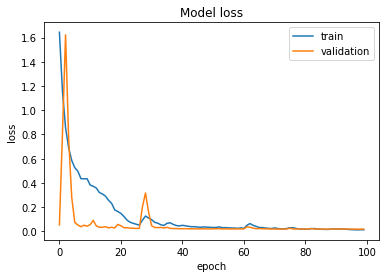

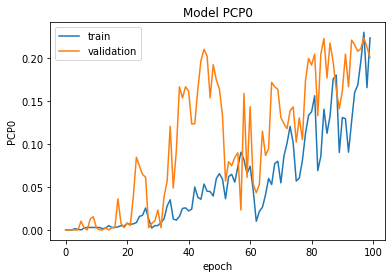

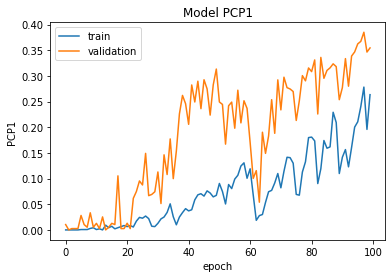

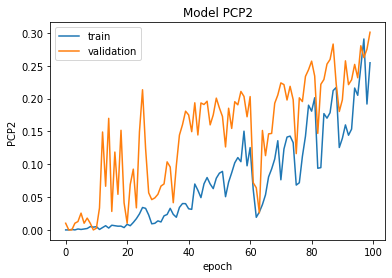

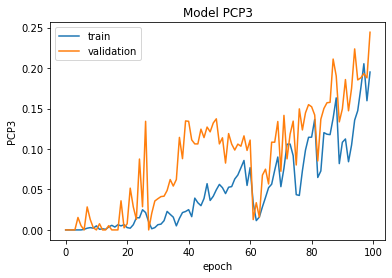

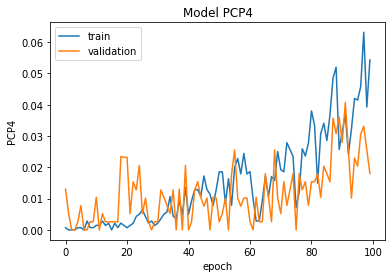

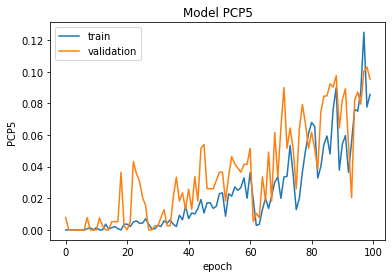

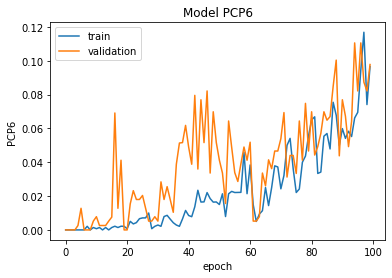

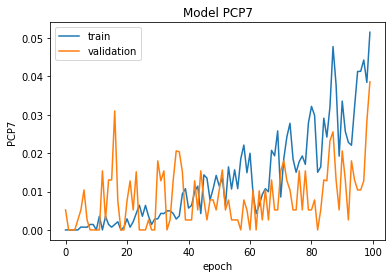

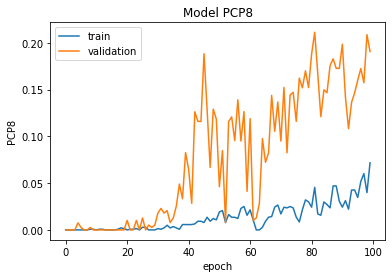

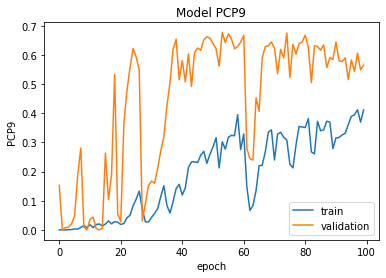

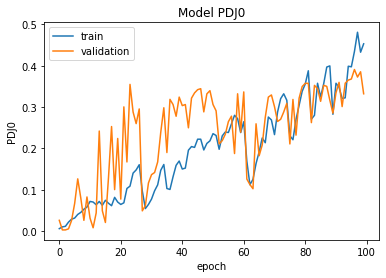

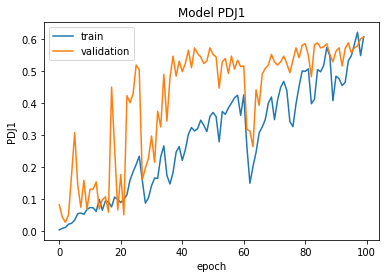

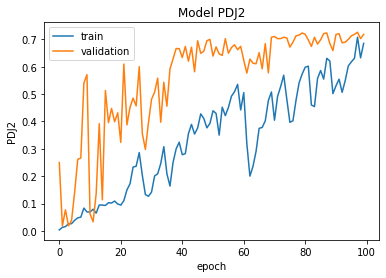

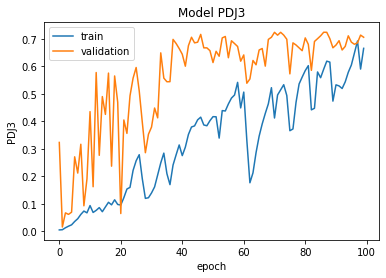

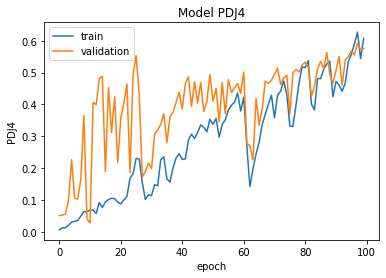

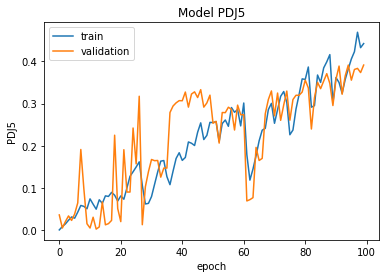

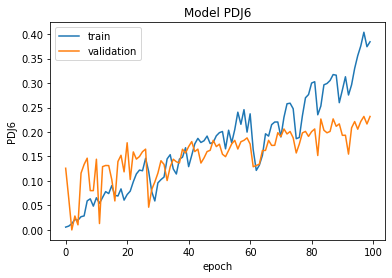

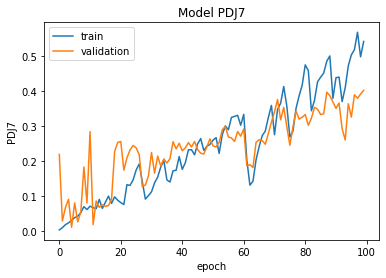

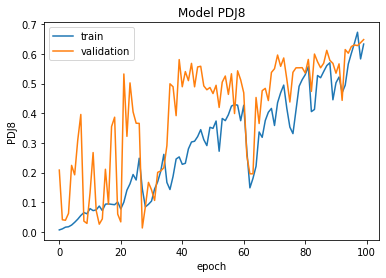

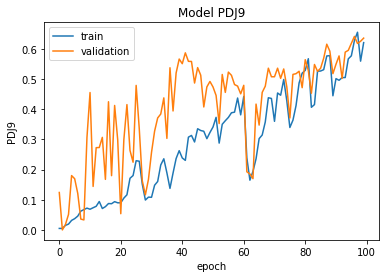

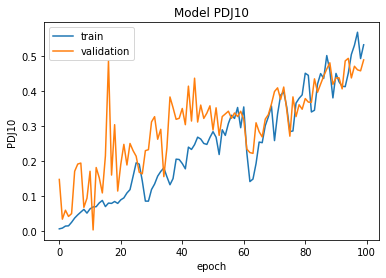

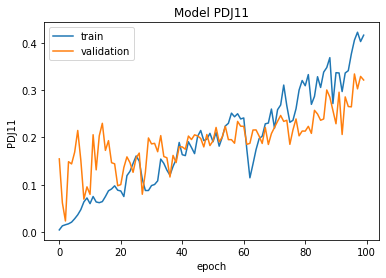

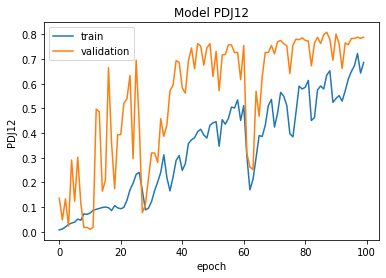

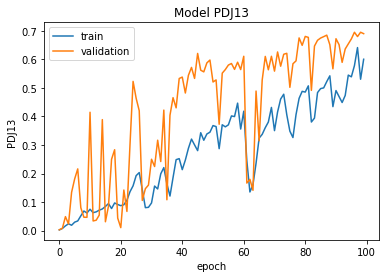


Train Results:
 - loss: 0.0126 - PCP0: 0.2240 - PCP1: 0.2635 - PCP2: 0.2546 - PCP3: 0.1951 - PCP4: 0.0543 - PCP5: 0.0856 - PCP6: 0.0965 - PCP7: 0.0515 - PCP8: 0.0717 - PCP9: 0.4118 - PDJ0: 0.4531 - PDJ1: 0.6083 - PDJ2: 0.6857 - PDJ3: 0.6658 - PDJ4: 0.6075 - PDJ5: 0.4423 - PDJ6: 0.3843 - PDJ7: 0.5411 - PDJ8: 0.6335 - PDJ9: 0.6210 - PDJ10: 0.5323 - PDJ11: 0.4163 - PDJ12: 0.6862 - PDJ13: 0.6006

Validation Results:
 - loss: 0.0186 - PCP0: 0.2010 - PCP1: 0.3546 - PCP2: 0.3011 - PCP3: 0.2443 - PCP4: 0.0180 - PCP5: 0.0952 - PCP6: 0.0978 - PCP7: 0.0386 - PCP8: 0.1906 - PCP9: 0.5651 - PDJ0: 0.3321 - PDJ1: 0.6075 - PDJ2: 0.7185 - PDJ3: 0.7062 - PDJ4: 0.5758 - PDJ5: 0.3913 - PDJ6: 0.2318 - PDJ7: 0.4015 - PDJ8: 0.6487 - PDJ9: 0.6359 - PDJ10: 0.4891 - PDJ11: 0.3215 - PDJ12: 0.7888 - PDJ13: 0.6903

Test Results:
 - loss: 0.0189 - PCP0: 0.2156 - PCP1: 0.2990 - PCP2: 0.3260 - PCP3: 0.2094 - PCP4: 0.0188 - PCP5: 0.0833 - PCP6: 0.0531 - PCP7: 0.0094 - PCP8: 0.1490 - PCP9: 0.5875 - PDJ0: 0.3979 - PDJ1:

In [12]:
keras.backend.clear_session()

n_epoch = 100
batch_size = 128
starting_lr = 0.0005

loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(starting_lr)

model = Sequential([Input(shape=(220, 220, 3)),
                    Conv2D(96, (11, 11), strides=(4, 4), padding='same'),
                    BatchNormalization(),
                    ReLU(),
                    MaxPooling2D((3, 3), strides=(2, 2)),
                    Conv2D(256, (5, 5), strides=(1, 1), padding='same'),
                    BatchNormalization(),
                    ReLU(),
                    MaxPooling2D((3, 3), strides=(2, 2)),
                    Conv2D(384, (3, 3), strides=(1, 1), padding='same'),
                    BatchNormalization(),
                    ReLU(),
                    Conv2D(384, (3, 3), strides=(1, 1), padding='same'),
                    BatchNormalization(),
                    ReLU(),
                    Conv2D(256, (3, 3), strides=(1, 1), padding='same'),
                    BatchNormalization(),
                    ReLU(),
                    MaxPooling2D((3, 3), strides=(2, 2)),
                    Flatten(),
                    Dense(4096),
                    BatchNormalization(),
                    ReLU(),
                    Dropout(0.4),
                    Dense(4096),
                    BatchNormalization(),
                    ReLU(),
                    Dropout(0.4),
                    Dense(28, activation='linear')])

# model.summary()

Train(model, n_epoch, batch_size, loss, optimizer, x_train, y_train, x_valid, y_valid, x_test, y_test)


## **Test Model**

1.


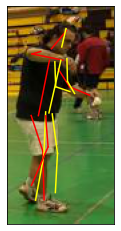

2.


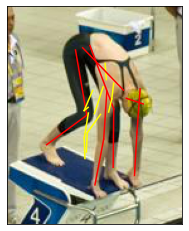

3.


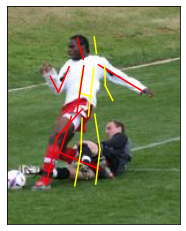

4.


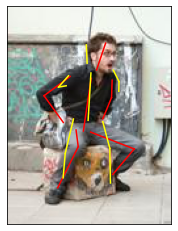

5.


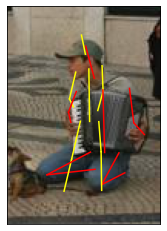

6.


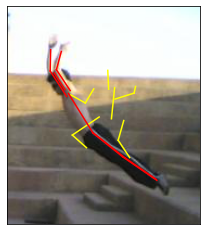

7.


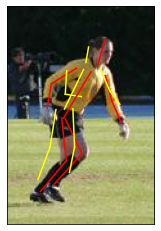

8.


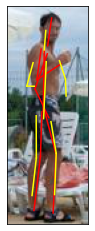

9.


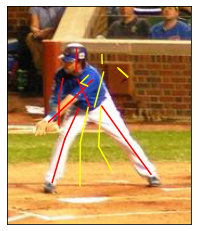

10.


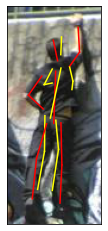

11.


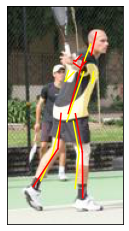

12.


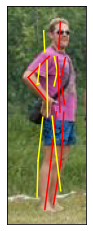

13.


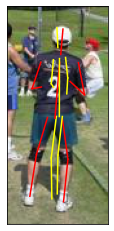

14.


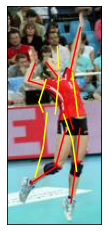

15.


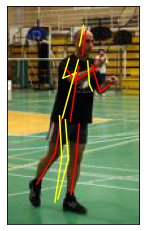

16.


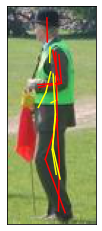

17.


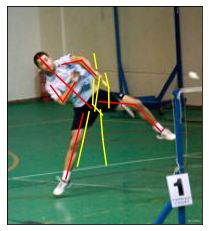

18.


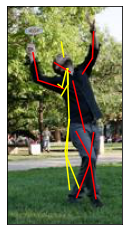

19.


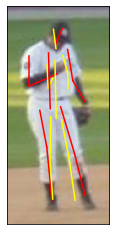

20.


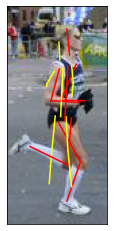

In [14]:
test_bias = 1700
joints_pred = model.predict(x_test).reshape((-1, 14, 2))

limbs_pred = get_limbs(joints_pred)
limbs_true = get_limbs(resized_joints[test_bias:])

for j in range(20):
  print(str(j + 1) + '.')
  plt.figure()
  plt.tick_params(left = False, labelleft = False,  labelbottom = False, bottom = False)
  plt.imshow(original_images[test_bias + j] / 255.0)
  for i in range(10):
    plt.plot((limbs_true[j, 2*i:2*i+2, 0] + 0.5) / original_scale[test_bias + j, 0], (limbs_true[j, 2*i:2*i+2, 1] + 0.5) / original_scale[test_bias + j, 1], color='red')
    plt.plot((limbs_pred[j, 2*i:2*i+2, 0] + 0.5) / original_scale[test_bias + j, 0], (limbs_pred[j, 2*i:2*i+2, 1] + 0.5) / original_scale[test_bias + j, 1], color='yellow')
  plt.show()
